Epoch 1/50
28/28 - 4s - loss: 0.0910 - val_loss: 0.0383 - 4s/epoch - 141ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0378 - val_loss: 0.0132 - 215ms/epoch - 8ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0122 - val_loss: 0.0339 - 230ms/epoch - 8ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0409 - val_loss: 0.0376 - 232ms/epoch - 8ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0470 - val_loss: 0.0896 - 287ms/epoch - 10ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0566 - val_loss: 0.0252 - 258ms/epoch - 9ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0207 - val_loss: 0.0117 - 279ms/epoch - 10ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0321 - val_loss: 0.0084 - 245ms/epoch - 9ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0089 - val_loss: 0.0091 - 263ms/epoch - 9ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0087 - val_loss: 0.0267 - 220ms/epoch - 8ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0035 - val_loss: 0.0140 - 289ms/epoch - 10ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0074 - val_loss: 0.0038 - 295ms/epoch - 11ms/step
Epoch 13/50
28/28 - 0s

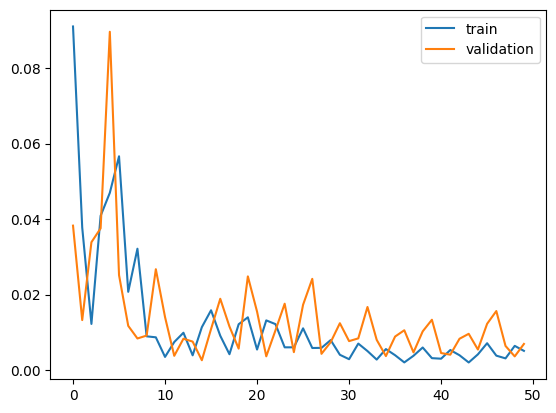

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 256)               168960    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 185473 (724.50 KB)
Trainable params: 185473 (724.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/home/vscode/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


None
0.08322215797210092


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot
from pickle import load

X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

#Parameters
LR = 0.001
BATCH_SIZE = 64
N_EPOCH = 50

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model

model = basic_lstm(input_dim, feature_size)
model.save('LSTM_3to1.h5')
print(model.summary())

yhat = model.predict(X_test, verbose=0)
#print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

In [8]:
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):


    train_yhat = model.predict(X_train, verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
    #
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Train RMSE -- ', RMSE)

    return RMSE






/tmp/ipykernel_7829/1685090021.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_7829/1685090021.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


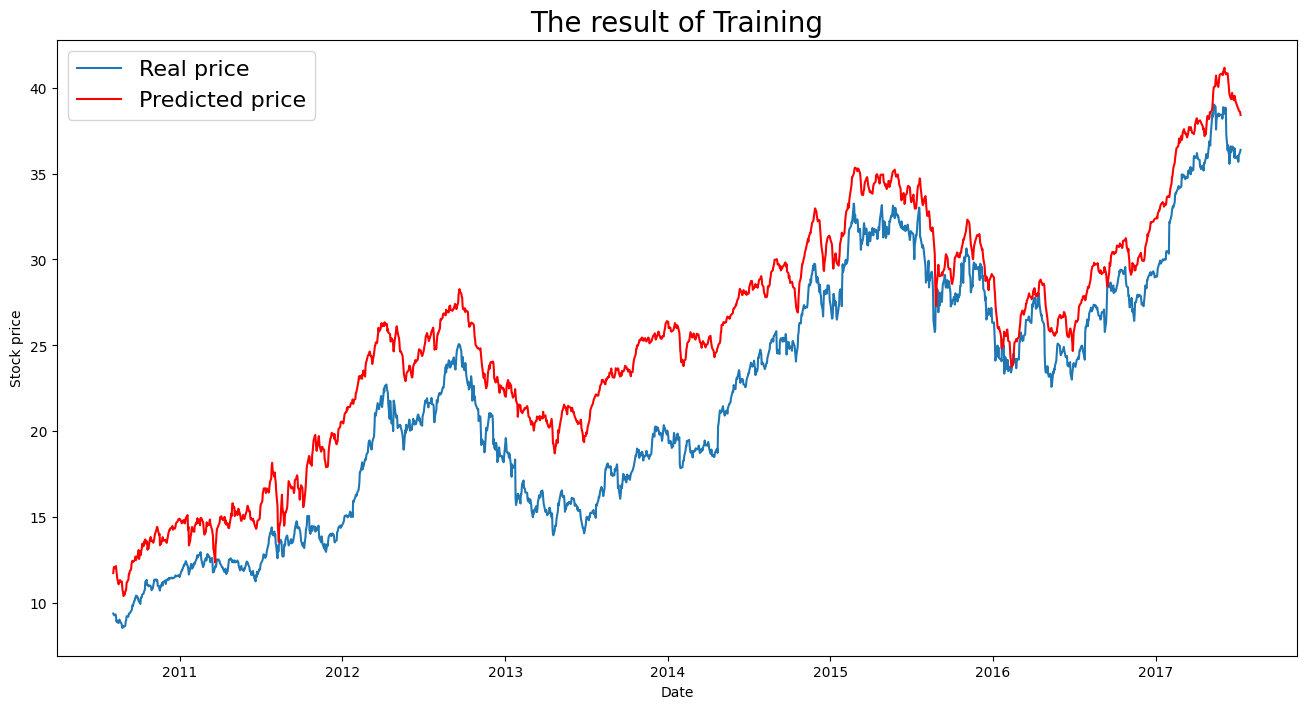

----- Train_RMSE_LSTM ----- 3.8201286734221


/tmp/ipykernel_7829/3165858476.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_7829/3165858476.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              NaN              NaN              NaN   
2019-12-23              NaN              NaN              NaN   
2019-12-24              NaN              NaN              NaN   
2019-12-26              NaN              NaN              NaN   
2019-12-27              NaN              NaN              NaN   
2019-12-30              NaN              NaN              NaN   
2019-12-31              NaN              NaN              NaN   

            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              

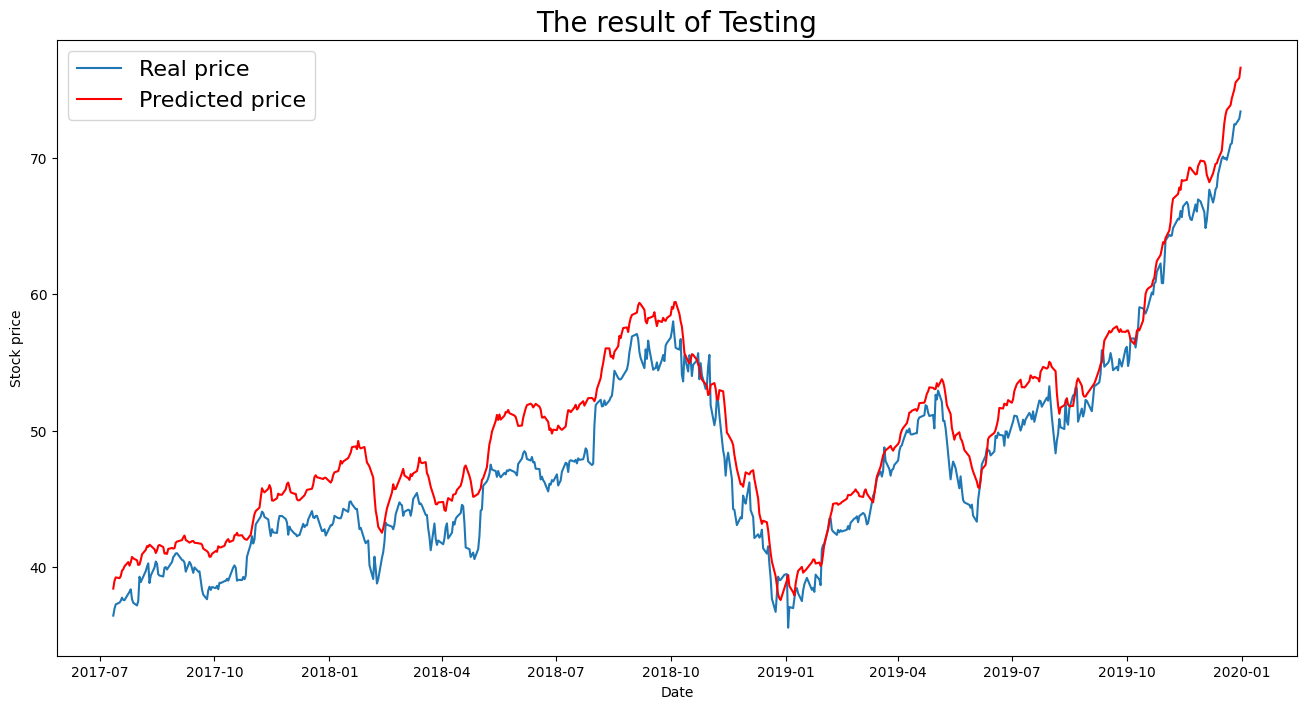

----- Test_RMSE_LSTM ----- 2.6722407345964796


/tmp/ipykernel_7829/3165858476.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_7829/3165858476.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


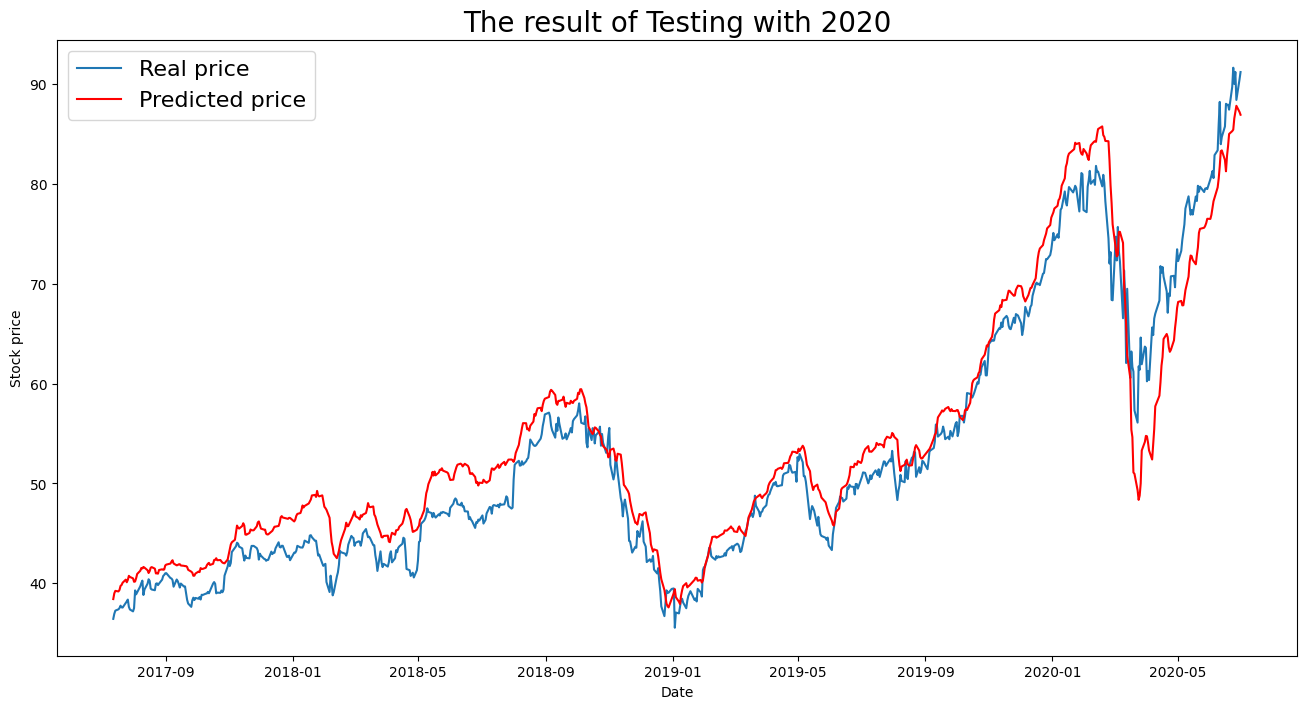

----- Test_RMSE_LSTM_with2020 ----- 3.45636487003576


'def plot_last3_testdataset_result(X_test, y_test):\n\n    test_yhat = model.predict(X_test[-1].reshape(1, X_test[-1].shape[0], X_test[-1].shape[1]), verbose=0)\n\n    X_scaler = load(open(\'X_scaler.pkl\', \'rb\'))\n    y_scaler = load(open(\'y_scaler.pkl\', \'rb\'))\n    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)\n\n    rescaled_real_y = y_scaler.inverse_transform(y_test[-32:])\n    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)\n\n    #print("----- test dataset rescaled predicted price -----", rescaled_predicted_y)\n    #print("----- test dataset SHAPE rescaled predicted price -----", rescaled_predicted_y.shape)\n\n    ## Real price\n    real_price = pd.DataFrame()\n    for i in range(rescaled_real_y.shape[0]):\n        test_predict_index = test_predict_index[-34:]\n        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],\n                               index=test_predict_index[i:i + output_dim])\n        real_price = pd

In [9]:
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE -- ', RMSE)

    return RMSE

def plot_testdataset_with2020_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2020", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE with 2020 -- ', RMSE)

    return RMSE

train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_LSTM -----", train_RMSE)

test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)

test_with2020_RMSE = plot_testdataset_with2020_result(X_test, y_test)
print("----- Test_RMSE_LSTM_with2020 -----", test_with2020_RMSE)




'''def plot_last3_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test[-1].reshape(1, X_test[-1].shape[0], X_test[-1].shape[1]), verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test[-32:])
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    #print("----- test dataset rescaled predicted price -----", rescaled_predicted_y)
    #print("----- test dataset SHAPE rescaled predicted price -----", rescaled_predicted_y.shape)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        test_predict_index = test_predict_index[-34:]
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    ## Predicted price
    predict_result = pd.DataFrame()
    y_predict = pd.DataFrame(rescaled_predicted_y[0], columns=["predicted_price"], index=test_predict_index[-3:])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    #plt.ylim(0, 110)
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of the last set of testdata", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real[-3:]))
    #print('-- test dataset RMSE -- ', RMSE)

    return RMSE'''


